In [32]:
from keras.models import Model
from keras.optimizers import SGD

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [5]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [8]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2002 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [9]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
125/125 [==============================] - 14s - loss: 0.7169 - acc: 0.5545 - val_loss: 0.6649 - val_acc: 0.5437
Epoch 2/50
125/125 [==============================] - 9s - loss: 0.6441 - acc: 0.6330 - val_loss: 0.6409 - val_acc: 0.6462
Epoch 3/50
125/125 [==============================] - 9s - loss: 0.5791 - acc: 0.6965 - val_loss: 0.6693 - val_acc: 0.6450
Epoch 4/50
125/125 [==============================] - 9s - loss: 0.5376 - acc: 0.7325 - val_loss: 0.6016 - val_acc: 0.6775
Epoch 5/50
125/125 [==============================] - 9s - loss: 0.4948 - acc: 0.7640 - val_loss: 0.5664 - val_acc: 0.7113
Epoch 6/50
125/125 [==============================] - 9s - loss: 0.4502 - acc: 0.8050 - val_loss: 0.6001 - val_acc: 0.7150
Epoch 7/50
125/125 [==============================] - 9s - loss: 0.4045 - acc: 0.8130 - val_loss: 0.5957 - val_acc: 0.7300
Epoch 8/50
125/125 [==============================] - 9s - loss: 0.3461 - acc: 0.8490 - val_loss: 0.7465 - val_acc: 0.7200
Epoch 9/50
125/

In [10]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [108]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train/',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/test/',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 2002 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [109]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [110]:
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [111]:
for i in validation_generator:
    print(i[1])
    break

[ 1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.]


In [112]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [116]:
x = base_model.output
x = Flatten()(x)
x = Dense(256)(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)

In [117]:
model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
            loss='binary_crossentropy', metrics=['accuracy'])

In [119]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('vgg16_first_try.h5')  # always save your weights after training or during training

Epoch 1/5
125/125 [==============================] - 91s - loss: 0.1317 - acc: 0.9570 - val_loss: 0.2256 - val_acc: 0.9075
Epoch 2/5
125/125 [==============================] - 91s - loss: 0.1097 - acc: 0.9700 - val_loss: 0.2476 - val_acc: 0.8975
Epoch 3/5
125/125 [==============================] - 91s - loss: 0.1109 - acc: 0.9695 - val_loss: 0.2068 - val_acc: 0.9175
Epoch 4/5
125/125 [==============================] - 91s - loss: 0.1099 - acc: 0.9690 - val_loss: 0.2127 - val_acc: 0.9187
Epoch 5/5
125/125 [==============================] - 91s - loss: 0.1069 - acc: 0.9695 - val_loss: 0.2178 - val_acc: 0.9125


In [59]:
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

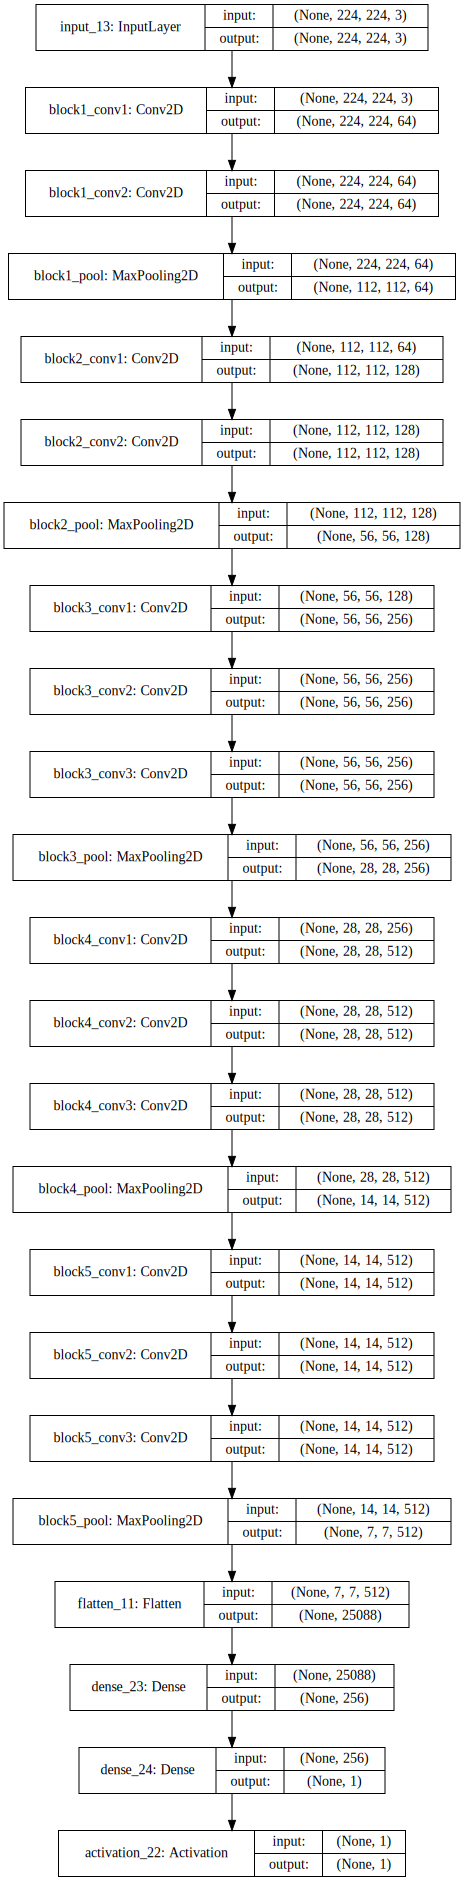

In [120]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))